In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import Color
import matplotlib as mpl

In [177]:
# Load all files
main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
landmarks = pd.read_csv(main_path+"/Papilionidae_landmarks.txt", sep="\t", header=None)
aligned = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

In [178]:
def convert_to_slice(df_subgroup):
    x_coords = df_subgroup[df_subgroup.iloc[:, 1] == "x-coordinates"].iloc[:, 2:].values
    y_coords = -df_subgroup[df_subgroup.iloc[:, 1] == "y-coordinates"].iloc[:, 2:].values
    return np.column_stack((x_coords.ravel(), y_coords.ravel()))

# Split dataframe by "Name" and convert each subgroup back to a 2D slice
groups = [group for _, group in aligned.groupby(aligned.iloc[:, 0])]
list_of_2d_slices = [convert_to_slice(group) for group in groups]
butterflies = np.dstack(list_of_2d_slices)

In [179]:
def select_species(species, meta, marks):
    idx = meta["species"]==species
    if np.sum(idx)==0:
        print("Species not found")
        return None
    return marks[:, :, idx], meta[idx]

In [180]:
def get_data(species=None):
    main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
    metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
    
    data = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

    metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
    
    groups = [group for _, group in data.groupby(data.iloc[:, 0])]
    list_of_2d_slices = [convert_to_slice(group) for group in groups]
    X = np.dstack(list_of_2d_slices)
    
    if species is not None:
        return select_species(species, metadata, X)
    else:
        return X, metadata

My work begins here


In [181]:
def sign_split(data):
    # split data into negative and positive x values
    neg = data[data[:, 0] < 0.]
    pos = data[data[:, 0] >= 0.]
    return neg, pos

In [182]:
def plot_butterfly(marks, s=2):
    plt.scatter(marks[:, 0], -marks[:, 1], s=s)
    plt.axis("equal")
    

In [183]:
def plot_wings(marks, sp=plt, scatter=False, dotsize=4):
    s = 50
    for n in [0, s]:
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        if scatter:
            sp.scatter(xs, ys, s=dotsize)
        else:
            sp.plot(xs, ys)

    sp.axis("equal")


Error in butterfly 5
Left wing has positive x-values at indices:	[0]
0.0022632309895891
-0.0022632309895891

Error in butterfly 9
Right wing has negative x-values at indices:	[74]
-0.0041158801509678
0.0041158801509678

Error in butterfly 10
Right wing has negative x-values at indices:	[74]
-0.0014062008559382
0.0014062008559382

Error in butterfly 15
Left wing has positive x-values at indices:	[49]
0.0019586789326583
-0.0019586789326583

Error in butterfly 25
Left wing has positive x-values at indices:	[ 0 49]
0.0023528768360081
-0.0023528768360081

Error in butterfly 57
Left wing has positive x-values at indices:	[0]
0.0006191122850011
-0.0006191122850011

Error in butterfly 62
Left wing has positive x-values at indices:	[ 0 49]
0.0005639750451853
-0.0005639750451853

Error in butterfly 65
Left wing has positive x-values at indices:	[0]
0.0024018005149101
-0.0024018005149101

Error in butterfly 76
Right wing has negative x-values at indices:	[74]
-0.0040783461417577
0.00407834614175

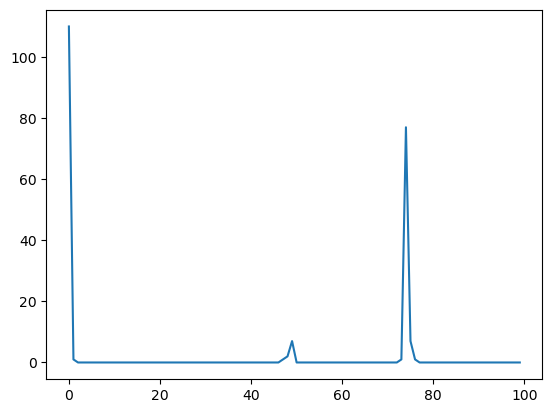

In [184]:
s = 50

def error_catch(marks):
    overlapR = False
    overlapL = False
    ro = None
    lo = None
    
    # indices of positive x-vals on left wing
    xl = np.where(marks[:s][:,0] > 0.)[0]
    if len(xl) > 0:
        #print(f'Left wing has positive x-values at indices {xl}')
        overlapR = True
        lo = xl
    
    # negative x-vals on right wing
    xr = np.where(marks[s:][:,0] < 0.)[0]
    if len(xr) > 0:
        #print(f'Right wing has negative x-values at indices {xr}')
        overlapL = True
        ro = xr + s     # Adjust index for right wing
    
    #for i in [0, 1, 50, 51, 98, 99]:
    #    print(marks[i,0])
    #
    #if marks[0,0] > 0.:
    #    print("error")
        
    return overlapL, overlapR, lo, ro

sample_size = butterflies.shape[2]

#errs = [(None,None) for i in range(sample_size)]
errs = np.zeros(100,dtype=int)
# list of erroneous indices
err_inds = []

fixed_butterflies = butterflies.copy()

np.set_printoptions(suppress=True)
for i in range(sample_size):
    flyi = butterflies[:, :, i]
    r, l, lo, ro = error_catch(flyi)
    
    if r or l:
        #errs[i] = (ro, lo)
        
        
        err_inds.append(i)
        print(f"\nError in butterfly {i}")
    if r:
        print(f"Right wing has negative x-values at indices:\t{ro}")
        for ind in ro:
            errs[ind] += 1
            fixed_butterflies[:, :, i][ind][0] = -butterflies[:, :, i][ind][0]
        print(butterflies[:, :, i][ro[0]][0])
        print(fixed_butterflies[:, :, i][ro[0]][0])
    
    if l:
        print(f"Left wing has positive x-values at indices:\t{lo}")
        for ind in lo:
            errs[ind] += 1
            fixed_butterflies[:, :, i][ind][0] = -butterflies[:, :, i][ind][0]
        print(butterflies[:, :, i][lo[0]][0])
        print(fixed_butterflies[:, :, i][lo[0]][0])

# show errs
#print(f'Number of errors: {len(err_inds)}')
#print('Error indices:')
#print(err_inds)
print(f'Sample size: {sample_size}')
# plot errs
plt.plot(errs)
mostErrs = np.argsort(errs)[::-1]

for i in range(100):
    
    print(mostErrs[i], '\t', errs[mostErrs[i]])

In [185]:
print(butterflies.shape)
print(fixed_butterflies.shape)

(100, 2, 2240)
(100, 2, 2240)


In [186]:
a = np.arange(10)
np.where(a < 5)

(array([0, 1, 2, 3, 4]),)

In [187]:
err_in = []
ers = [(None,None) for i in range(sample_size)]
for i in range(sample_size):
    r, l, lo, ro = error_catch(fixed_butterflies[:, :, i])
    
    if r or l:
        ers[i] = (ro, lo)
        err_in.append(i)
        print(f"\nError in butterfly {i}")
    if r:
        print(f"Right wing has negative x-values at indices:\t{ro}")
        print(fixed_butterflies[:, :, i][ro])
        print(butterflies[:, :, i][ro])
        #fixed_butterflies[:, :, i][ro] = - butterflies[:, :, i][ro]
    
    if l:
        print(f"Left wing has positive x-values at indices:\t{lo}")
        print(fixed_butterflies[:, :, i][lo])
        print(butterflies[:, :, i][lo])
        #fixed_butterflies[:, :, i][lo] = - butterflies[:, :, i][lo]

# show errs
print(f'Number of errors: {len(err_in)}')
print('Error indices:')
print(err_in)
print(f'Sample size: {sample_size}')

Number of errors: 0
Error indices:
[]
Sample size: 2240


In [188]:



print(butterflies[:,:,err_inds][:50][24,0])

#print(fixed_butterflies[:,:,5][:50,0])
#print(fixed_butterflies[:,:,5][0,0])

[-0.07841286 -0.0622803  -0.07837585 -0.06068859 -0.05793796 -0.07095435
 -0.06455249 -0.05752893 -0.06909128 -0.07077449 -0.06540862 -0.05315905
 -0.07192803 -0.06374847 -0.08663865 -0.06135505 -0.06710621 -0.07405087
 -0.08504937 -0.06477249 -0.07154295 -0.06565877 -0.06946429 -0.07213765
 -0.0550325  -0.07064814 -0.07467282 -0.07791843 -0.07646075 -0.06483559
 -0.07243026 -0.06446875 -0.05698103 -0.0541965  -0.06938898 -0.07556006
 -0.08308142 -0.0603803  -0.07256845 -0.07282318 -0.07767594 -0.07424664
 -0.07227111 -0.07893597 -0.06378414 -0.08040165 -0.07530643 -0.06940991
 -0.0848389  -0.06966617 -0.07852119 -0.07986551 -0.07811166 -0.07614424
 -0.08474803 -0.06770061 -0.06063398 -0.07629436 -0.06314946 -0.07922717
 -0.076577   -0.07949953 -0.07719623 -0.07327711 -0.07045732 -0.07545969
 -0.06882604 -0.07084934 -0.07690919 -0.08291708 -0.07929047 -0.06984276
 -0.07326797 -0.07129165 -0.06851829 -0.07137369 -0.07343134 -0.07025371
 -0.07240166 -0.07366306 -0.071769   -0.07124051 -0

In [189]:
butterflies, metadata = get_data()

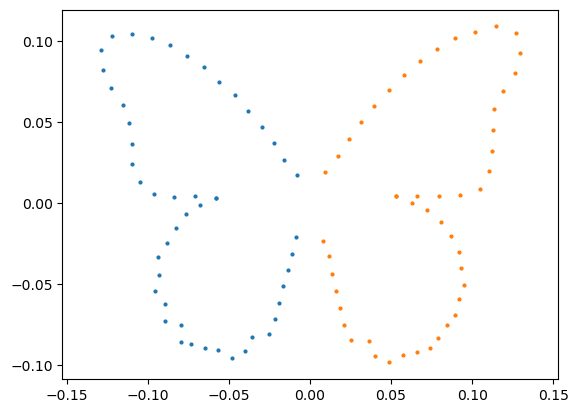

In [190]:
butterflies, _ = get_data()

plot_wings(marks=fixed_butterflies[:, :, 0], scatter=True, dotsize=4)

In [191]:
print(metadata)

              id                                 filename  \
0     1039027751                 1039027751_0_default.jpg   
1     1039028343             1039028343_0_default.jpg.jpg   
2     1039033323                 1039033323_0_default.jpg   
3     1039033725             1039033725_0_default.jpg.jpg   
4     1039037014             1039037014_0_default.jpg.jpg   
...          ...                                      ...   
2235   932851331              932851331_0_default.jpg.jpg   
2236   932851418              932851418_0_default.jpg.jpg   
2237   932851590  932851590_2011_07_19_IMG_091426.JPG.jpg   
2238   932851670              932851670_0_default.jpg.jpg   
2239   932851678              932851678_0_default.jpg.jpg   

                  species   latitude   longitude        family        order  \
0        Battus polydamas  26.805403  -82.280023  Papilionidae  Lepidoptera   
1     Papilio aristodemus  24.772380  -81.453743  Papilionidae  Lepidoptera   
2        Battus polydamas     

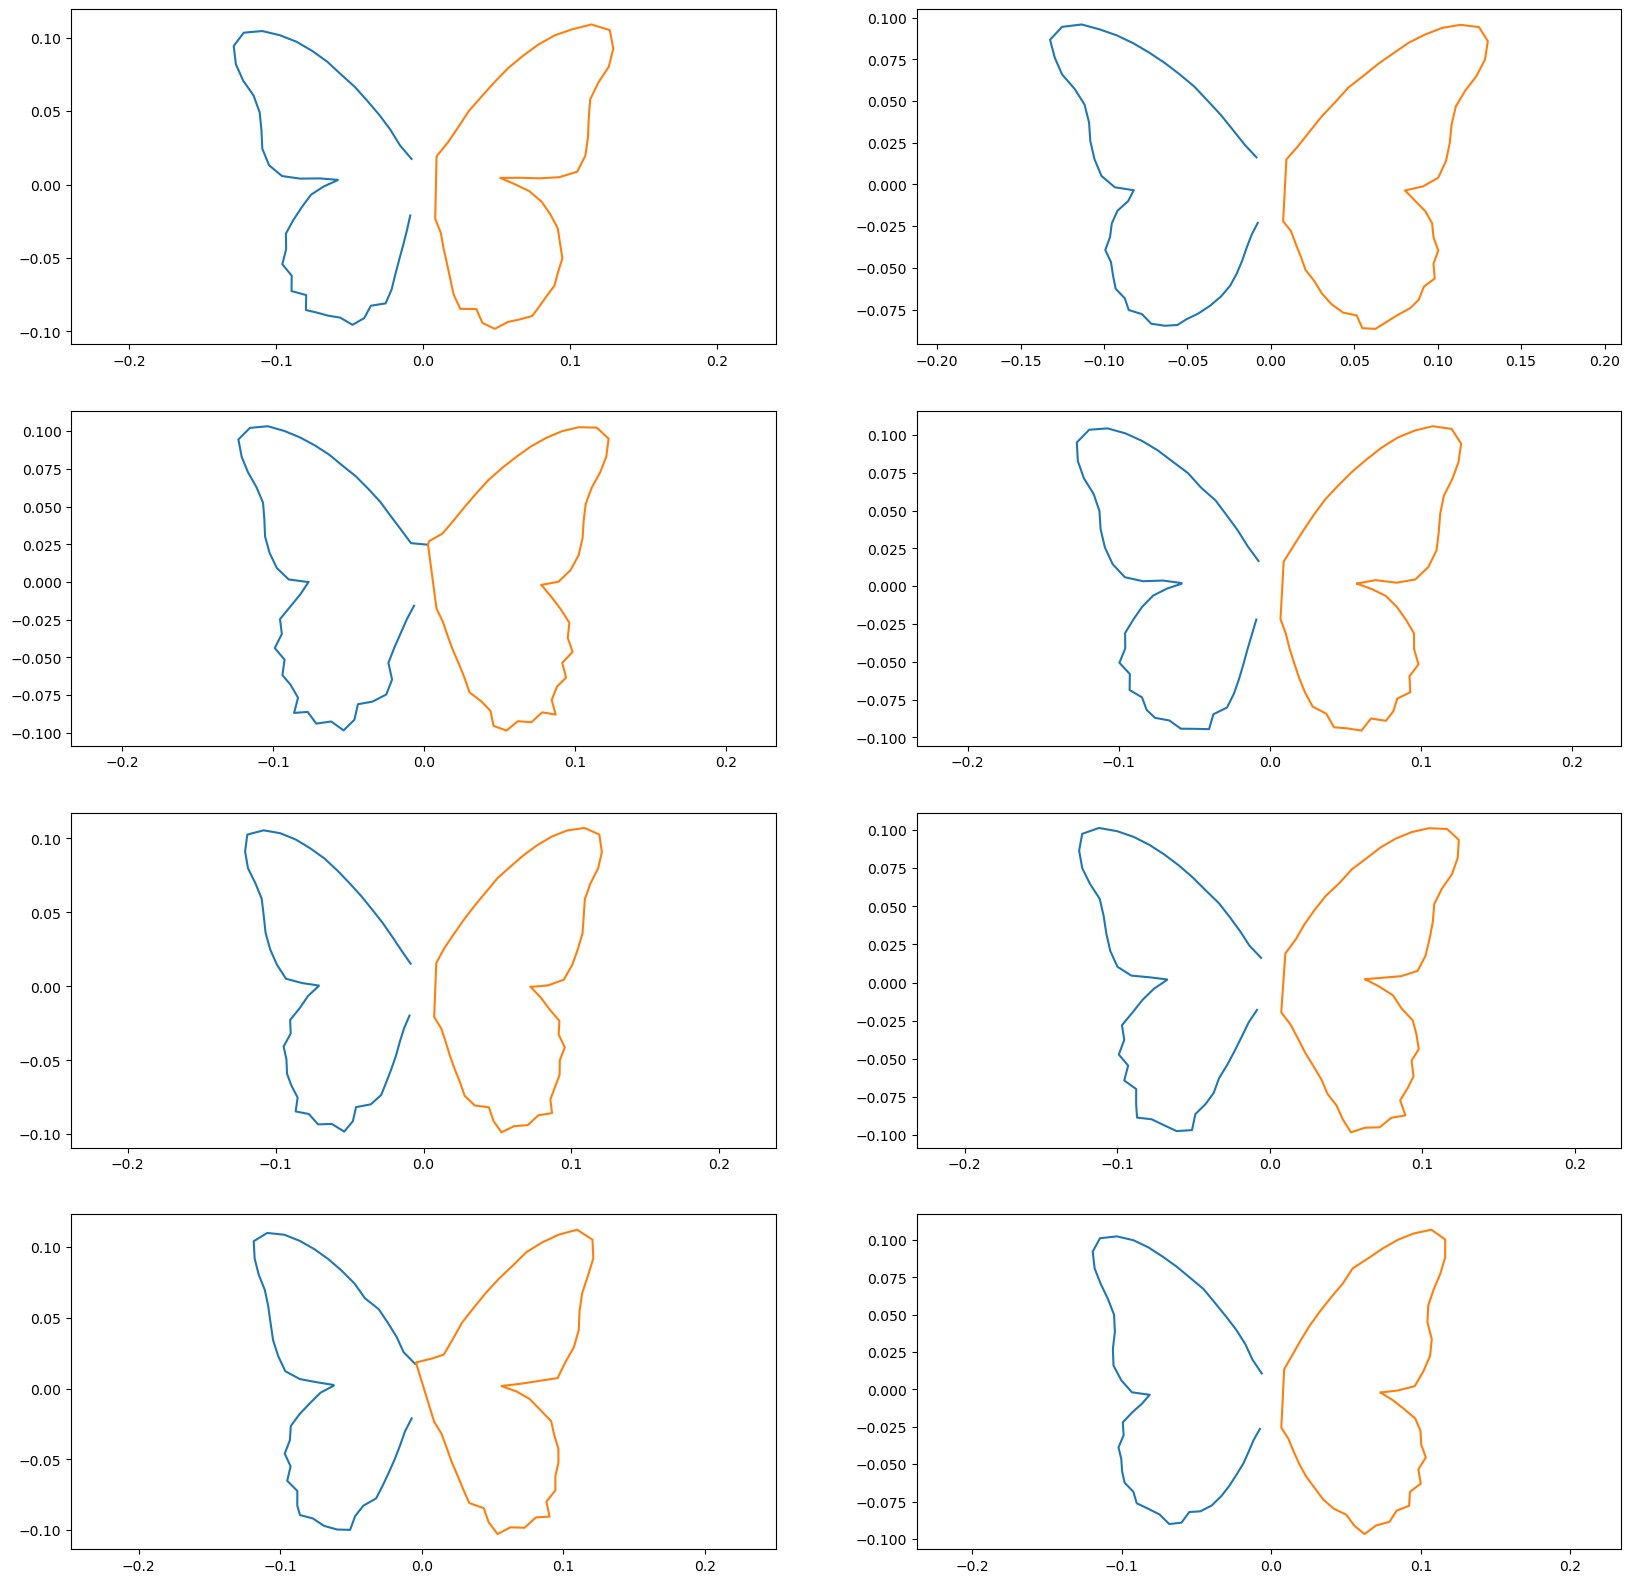

In [192]:
def plot_points(marks, n_row, n_col, meta=None):
    f = plt.figure(figsize=(20, 20))
    for i in range(n_row * n_col):

        sp = plt.subplot(n_row, n_col, i + 1)
        #plot_butterfly(marks[:, :, i])#, title=meta["species"][i])
        plot_wings(marks[:, :, i], sp)

        if meta is not None:
            sp.set_title(meta["species"][i])  # Fix: Replace sp.title with sp.set_title

battus_landmarks, battus_metadata = select_species("Battus polydamas", metadata, butterflies)
plot_points(battus_landmarks, 4, 2)


In [193]:

#for ind in err_inds:
#    merg = np.stack([butterflies[:,:,ind],fixed_butterflies[:,:,ind]], axis=2)
#    plot_points(merg, 1, 2)


In [194]:
#for ind in err_inds:
#    plot_points(butterflies[:, :, ind], 4, 2)

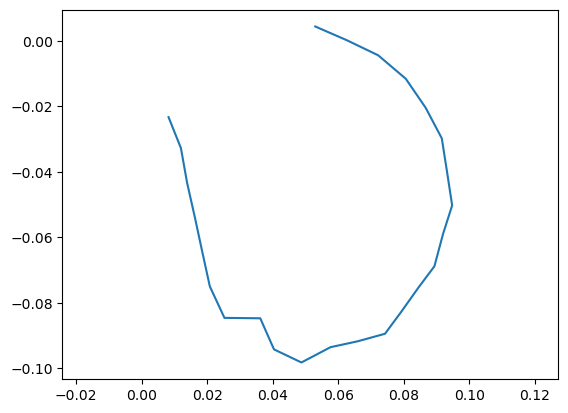

In [195]:
plot_wings(butterflies[75:100,:,0])

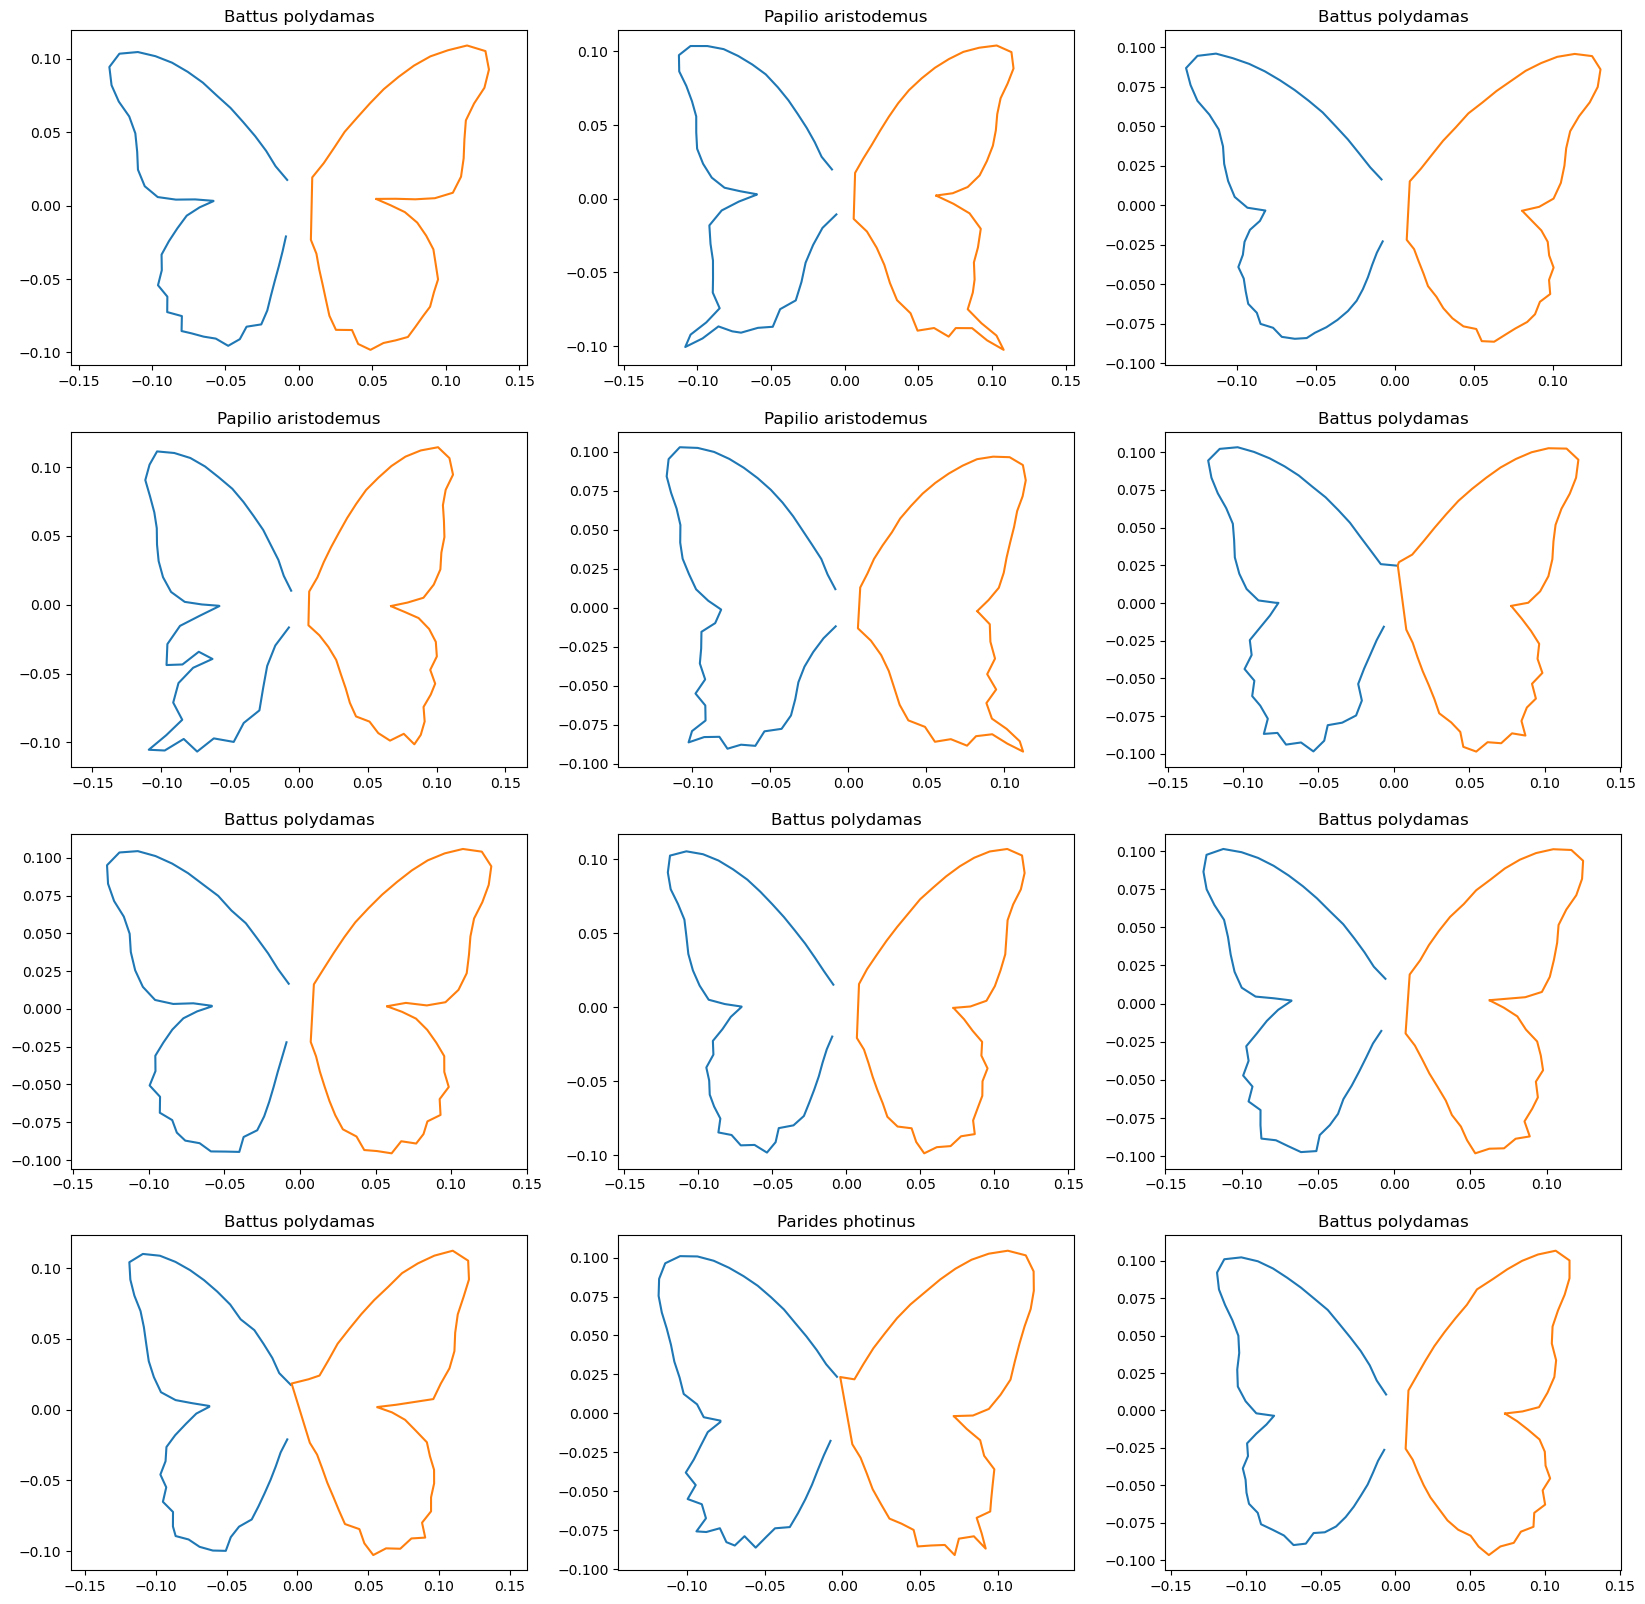

In [196]:
plot_points(butterflies, 4, 3, metadata)

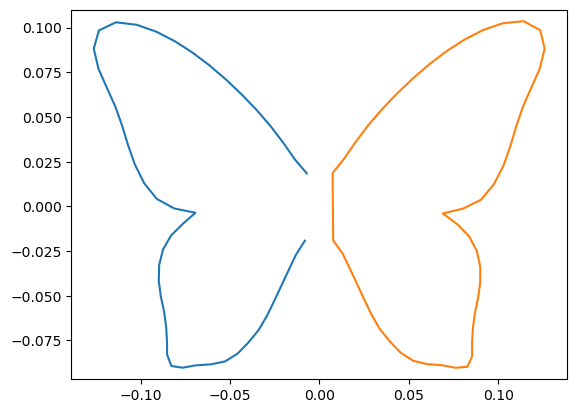

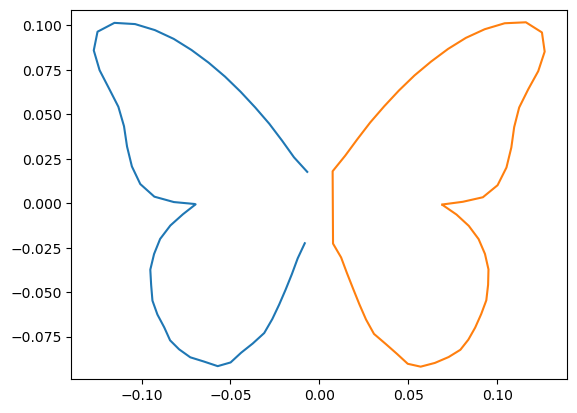

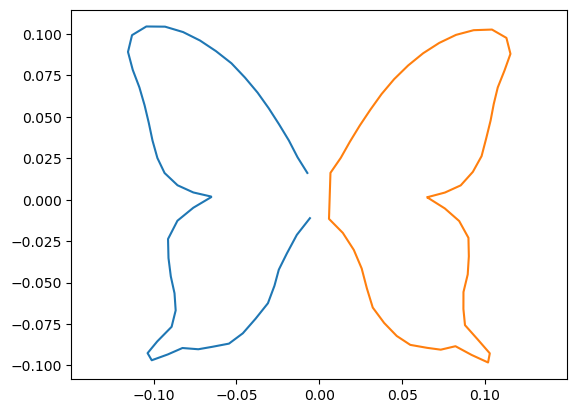

In [197]:
mean_butterfly = np.mean(butterflies, axis=2)
plot_wings(mean_butterfly)
plt.show()

battus_landmarks, _ = select_species("Battus polydamas", metadata, butterflies)
mean_battus = np.mean(battus_landmarks, axis=2)
plot_wings(mean_battus)
plt.show()

airstodemus_landmarks, _ = select_species("Papilio aristodemus", metadata, butterflies)
mean_aristodemus = np.mean(airstodemus_landmarks, axis=2)
plot_wings(mean_aristodemus)
plt.show()

In [198]:
def flat(marks):
    dims = len(marks.shape)
    if dims == 2:
        print("called flat() on 2d array, nothing happened.")
        return marks.reshape(marks.shape[0]*marks.shape[1])
    elif dims == 3:
        return marks.reshape(marks.shape[0]*marks.shape[1], marks.shape[2])
    else:
        raise ValueError("Invalid number of dimensions")

def unflat(marks, d=2):
    dims = len(marks.shape)
    if dims == 1:
        return marks.reshape(marks.shape[0]//d, d)
    elif dims == 2:
        return marks.reshape(marks.shape[0]//d, d, marks.shape[1])
    else:
        raise ValueError("Invalid number of dimensions")
    

print(flat(battus_landmarks).shape, battus_landmarks.shape)
print(flat(butterflies).shape, butterflies.shape)

(200, 118) (100, 2, 118)
(200, 2240) (100, 2, 2240)


In [199]:
a = np.arange(30).reshape(3, 2, 5)
b = flat(a)
c = unflat(b)
print(a, '\n\n', b, '\n\n', c)


[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]] 

 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]] 

 [[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]]


(100, 2, 118)
(200, 118)
(200,)
(100, 2)


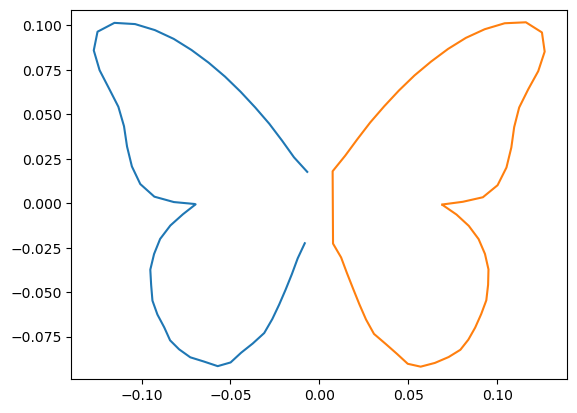

In [200]:
# the flat of the mean is the mean of the flat

x = battus_landmarks
print(x.shape)

x = flat(x)
print(x.shape)

x = np.mean(x, axis=1)
print(x.shape)

x = unflat(x)
print(x.shape)

# see if the arrays are equal, proving the point
np.allclose(mean_battus, x)

plot_wings(x)

(100, 2, 2240)
(200, 2240)
(200,)
(200, 2240)
(100, 2)
(100, 2, 2240)


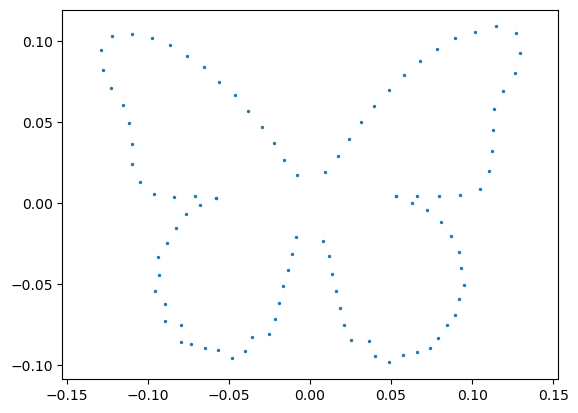

In [201]:
flatflies = flat(butterflies)
print(butterflies.shape)
print(flatflies.shape)
mean = np.mean(flatflies, axis=1)
cent = flatflies - mean[:, None]
print(mean.shape)
print(cent.shape)

mn = unflat(mean)
cnt = unflat(cent)
print(mn.shape)
print(cnt.shape)

uncent = unflat(cent + mean[:, None])

#plot_butterfly(mn)
plot_butterfly(uncent[:,:,0])

In [202]:
def pca_old(data):
    X = flat(data)
    
    # center data
    X_mean = np.mean(X, axis=1)
    X_cent = X - X_mean[:,None]
    
    # get eigenvectors and eigenvalues from covariance matrix
    cov_mat = np.cov(X_cent)
    PCevals, PCevecs = np.linalg.eigh(cov_mat)
    
    return PCevals[::-1], PCevecs[::-1], cov_mat, X_cent, X_mean


In [203]:
print(7%2)

1


In [204]:
(m,n) = flat(butterflies).shape
print(m,n)
(x,y) = butterflies[:,:,0][0]
xm = np.mean(b, axis=0)
print(x,y)

200 2240
-0.0079682097166611 -0.0174724657331868


Results of code below: data is Procrustes superimposed to remove translation and rotation, but not removing scale differences (RMSD differs). 

In [205]:
def rmsd(b):
    (k,two) = b.shape
    if (two != 2) or (k%2 != 0): raise ValueError("Invalid dimensions")
    s = 0.
    
    (xm, ym) = np.mean(b, axis=0)
    ms = [xm, ym]
    
    for i in [0,1]:
        if abs(ms[i]) < 1e-10:
            s += np.sum(np.square(b[i]))
        else:
            print("!")
            s += np.sum(np.square(np.add(b[i], ms[i])))
    
    return np.sqrt(s)/k

for i in range(25):
    print(rmsd(butterflies[:,:,i]))
    

0.0003659054084933358
0.0003904680803175863
0.00033944537297293895
0.0002641282405076019
0.0002908482616476527
0.0003683443665656455
0.00035281971338995023
0.0003360165421799366
0.0003256923571931613
0.00034140351073908877
0.0004080974745989475
0.00026646437616686394
0.0004278977965683839
0.0002528420850465219
0.000296876794481119
0.0004609252771084992
0.0003206188334987116
0.00030289270680590474
0.00024242746756780126
0.000298121229906779
0.0003537607145801578
0.00034064496205354395
0.0003957673186578987
0.00033241046095104995
0.0003273652789806776


In [206]:
# data is already centered
for i in range(2240):
    print(np.mean(butterflies[:, :, i], axis=0))

[0. 0.]
[0. 0.]
[ 0. -0.]
[0. 0.]
[-0. -0.]
[ 0. -0.]
[-0.  0.]
[-0.  0.]
[-0. -0.]
[ 0. -0.]
[-0. -0.]
[-0. -0.]
[-0.  0.]
[-0. -0.]
[0. 0.]
[-0. -0.]
[0. 0.]
[-0.  0.]
[-0.  0.]
[-0. -0.]
[-0. -0.]
[0. 0.]
[-0.  0.]
[-0.  0.]
[-0. -0.]
[0. 0.]
[ 0. -0.]
[-0. -0.]
[0. 0.]
[0. 0.]
[-0.  0.]
[ 0. -0.]
[-0. -0.]
[-0. -0.]
[0. 0.]
[-0. -0.]
[-0. -0.]
[ 0. -0.]
[-0.  0.]
[-0. -0.]
[-0.  0.]
[-0.  0.]
[ 0. -0.]
[-0. -0.]
[-0. -0.]
[0. 0.]
[0. 0.]
[ 0. -0.]
[-0. -0.]
[-0.  0.]
[-0. -0.]
[0. 0.]
[-0.  0.]
[ 0. -0.]
[0. 0.]
[0. 0.]
[-0. -0.]
[0. 0.]
[ 0. -0.]
[-0.  0.]
[ 0. -0.]
[0. 0.]
[-0. -0.]
[0. 0.]
[-0.  0.]
[0. 0.]
[ 0. -0.]
[ 0. -0.]
[0. 0.]
[ 0. -0.]
[ 0. -0.]
[0. 0.]
[-0. -0.]
[-0. -0.]
[-0. -0.]
[-0. -0.]
[ 0. -0.]
[ 0. -0.]
[-0.  0.]
[-0.  0.]
[-0. -0.]
[0. 0.]
[0. 0.]
[-0. -0.]
[-0.  0.]
[-0.  0.]
[ 0. -0.]
[-0.  0.]
[0. 0.]
[-0. -0.]
[-0. -0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.  0.]
[-0. -0.]
[ 0. -0.]
[0. 0.]
[-0.  0.]
[ 0. -0.]
[-0. -0.]
[0. 0.]
[-0. -0.]
[ 0. -0.]
[-0.  0.]
[0. 0.]


In [207]:
print(np.sum(np.square([2.,4.])))

20.0


In [208]:

print(np.add([2.,4.], -1.5))

[0.5 2.5]


In [209]:

#print(butterflies.shape)
X = flat(butterflies)
(m,n) = X.shape

but0 = butterflies[:, :, 0]
print(but0.shape)
(xm,ym) = np.mean(but0, axis=0)

print(xm,ym)
ms = [xm, ym]
for i in [0,1]:
    
    if abs(ms[i]) < 1e-10:
        ms[i] = 0.
(xm, ym) = ms
print(xm,ym)


(100, 2)
2.796374243274613e-17 1.3817072486155268e-17
0.0 0.0


In [210]:
X_mean = np.mean(X, axis=1)
#plot_wings(unflat(X_mean))
X_cent = X - X_mean[:,None]
print(X_cent.shape)

(200, 2240)


In [211]:
rank = np.linalg.matrix_rank(X)
print(f'{m}\ttraits')
print(f'{rank}\trank')
print(f'{m-rank}\tdegrees of freedom removed' )

200	traits
197	rank
3	degrees of freedom removed


In [223]:
a1 = np.arange(6.).reshape(2, 3)
print(a1)
print(np.sqrt(a1))

[[0. 1. 2.]
 [3. 4. 5.]]
[[0.         1.         1.41421356]
 [1.73205081 2.         2.23606798]]


In [213]:

X = flat(butterflies)
(m,n) = X.shape
print(m,n)
# center data
X_mean = np.mean(X, axis=1)
X_cent = X - X_mean[:, None]

# get eigenvectors and eigenvalues from covariance matrix
P1 = np.cov(X_cent)
P2 = ((n-1)**(-1) * X_cent) @ (X_cent.T)    # a little more precise than P3 when comparing to P1 (less floating point loss)
P3 = ((n-1)**(-1)) * (X_cent @ (X_cent.T))  # a liitle more precise than P2 when checking symmetry


print(np.allclose(P1, P2, 1e-11, 0.))
print(np.allclose(P1, P3, 1e-11, 0.))
print(np.allclose(P1, P3, 1e-10, 0.))

# P1 and P3 pass symmetry 
print((np.array_equal(P1, P1.T))) #symmetric?
print((np.array_equal(P2, P2.T))) 
print((np.array_equal(P3, P3.T)))




200 2240
True
False
True
True
False
True


Singular values (S) and eigenvalues (evals) differ most significantly at the last indices with smallest values

In [214]:

U, S, Vh = np.linalg.svd(P3, hermitian=True)    # SVD
Sig = np.diag(S)

evals, evecs = (np.linalg.eig(P3))
diff = (evals - S)    

print(evals)
# F print(np.array_equal(evals[:10],S[:10]))
# F rint((np.array_equal(S, evals)))
#print(np.allclose(S[:20], evals[:20], 1e-10, 0.))

[ 0.00471805+0.j  0.00246703+0.j  0.00116281+0.j  0.00090271+0.j
  0.00048156+0.j  0.00022614+0.j  0.00018087+0.j  0.00011892+0.j
  0.00011237+0.j  0.00008898+0.j  0.00007769+0.j  0.00006061+0.j
  0.00004864+0.j  0.00004767+0.j  0.00003757+0.j  0.0000366 +0.j
  0.00002804+0.j  0.0000247 +0.j  0.00002308+0.j  0.00001914+0.j
  0.0000178 +0.j  0.00001551+0.j  0.00001492+0.j  0.00001338+0.j
  0.00001177+0.j  0.00001127+0.j  0.00001043+0.j  0.00000993+0.j
  0.0000091 +0.j  0.00000821+0.j  0.00000789+0.j  0.0000075 +0.j
  0.00000702+0.j  0.00000671+0.j  0.00000592+0.j  0.00000565+0.j
  0.00000519+0.j  0.00000495+0.j  0.00000483+0.j  0.0000045 +0.j
  0.00000437+0.j  0.00000408+0.j  0.000004  +0.j  0.00000395+0.j
  0.00000378+0.j  0.00000358+0.j  0.00000347+0.j  0.00000338+0.j
  0.00000307+0.j  0.00000312+0.j  0.00000292+0.j  0.00000281+0.j
  0.00000265+0.j  0.00000254+0.j  0.00000238+0.j  0.00000231+0.j
  0.00000228+0.j  0.00000219+0.j  0.00000214+0.j  0.00000197+0.j
  0.00000193+0.j  0.00000

In [230]:
def pca(data):

    X = (flat(butterflies))   # X(mxn)
    (m,n) = X.shape
    # print(m,n)
    
    # center data
    X_cent = X - (np.mean(X, axis=1))[:,None]
    
    # covariance matrix P
    #P = ((n-1)**(-1)) * (X_cent @ (X_cent.T))
    P = np.cov(X_cent)
    U, S, Vh = np.linalg.svd(P, hermitian=True)    # Sv is eigenvalues, not singular values (same notation as my ref)
    #Sig = np.diag(S)
    #Scores = (X_cent.T) @ U      # not sure why X dims are flipped from reference math

    return U, S, Vh



[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [216]:
print([])

[]


In [217]:
# transforms data from D to K dimensions
def transform(X, PCevecs, K=2):
    # select the eigenvectors corresponding to the K largest eigenvalues
    W = PCevecs[:, -K:]
    # project the data onto those components
    return X.T @ W

In [218]:
evals, evecs, cov, data_flatcent, data_flatmean = pca(butterflies)
features = transform(data_flatcent, evecs, K=2)
print(evals.shape)
print(evecs.shape)
print(evals[-10:])

for e in evals[-10:]:
    print(e)

(200,)
(200, 200)
[ 0.00000001  0.00000001  0.00000001  0.          0.          0.
  0.          0.         -0.         -0.        ]
9.086899707884709e-09
6.926777680948063e-09
5.849205686760414e-09
1.5331938867135456e-09
1.1750808184322557e-09
2.590383790430469e-10
2.288291257070183e-19
1.5559191691463543e-20
-2.3719494711728177e-21
-1.9205704083019493e-20


In [219]:
print(evals[0], evals[199])
n=3
a = np.arange(-n, n+1)
print(a)

0.004718051771849079 -1.9205704083019493e-20
[-3 -2 -1  0  1  2  3]


Proportion of variance explained by the first 1 principal components: 0.42275246822296253
Proportion of variance explained by the first 2 principal components: 0.643806322260234
Proportion of variance explained by the first 3 principal components: 0.7479976466808124
Proportion of variance explained by the first 4 principal components: 0.8288833383513163
Proportion of variance explained by the first 5 principal components: 0.8720324772318325
Proportion of variance explained by the first 6 principal components: 0.8922953084071006
Proportion of variance explained by the first 7 principal components: 0.9085019977558567
Proportion of variance explained by the first 8 principal components: 0.9191574978452733
Proportion of variance explained by the first 9 principal components: 0.9292258768242936
Proportion of variance explained by the first 10 principal components: 0.9371985831909271


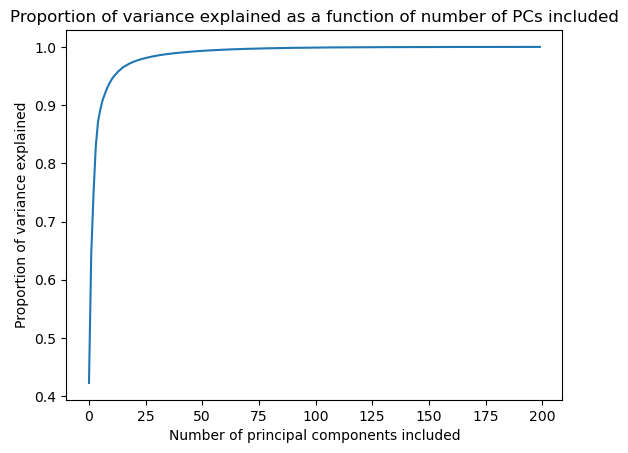

In [220]:
# reverse eigenvector order
#evals_hi2lo = evals[::-1]

# variance explaned by first k components
variance_explained_per_component = evals/np.sum(evals)
cumulative_variance_explained = np.cumsum(variance_explained_per_component)

plt.plot(cumulative_variance_explained)
plt.xlabel('Number of principal components included')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained as a function of number of PCs included')

# Let's print out the proportion of variance explained by the first 10 PCs
for i in range(10):
    print('Proportion of variance explained by the first '+str(i+1)+' principal components:', cumulative_variance_explained[i])

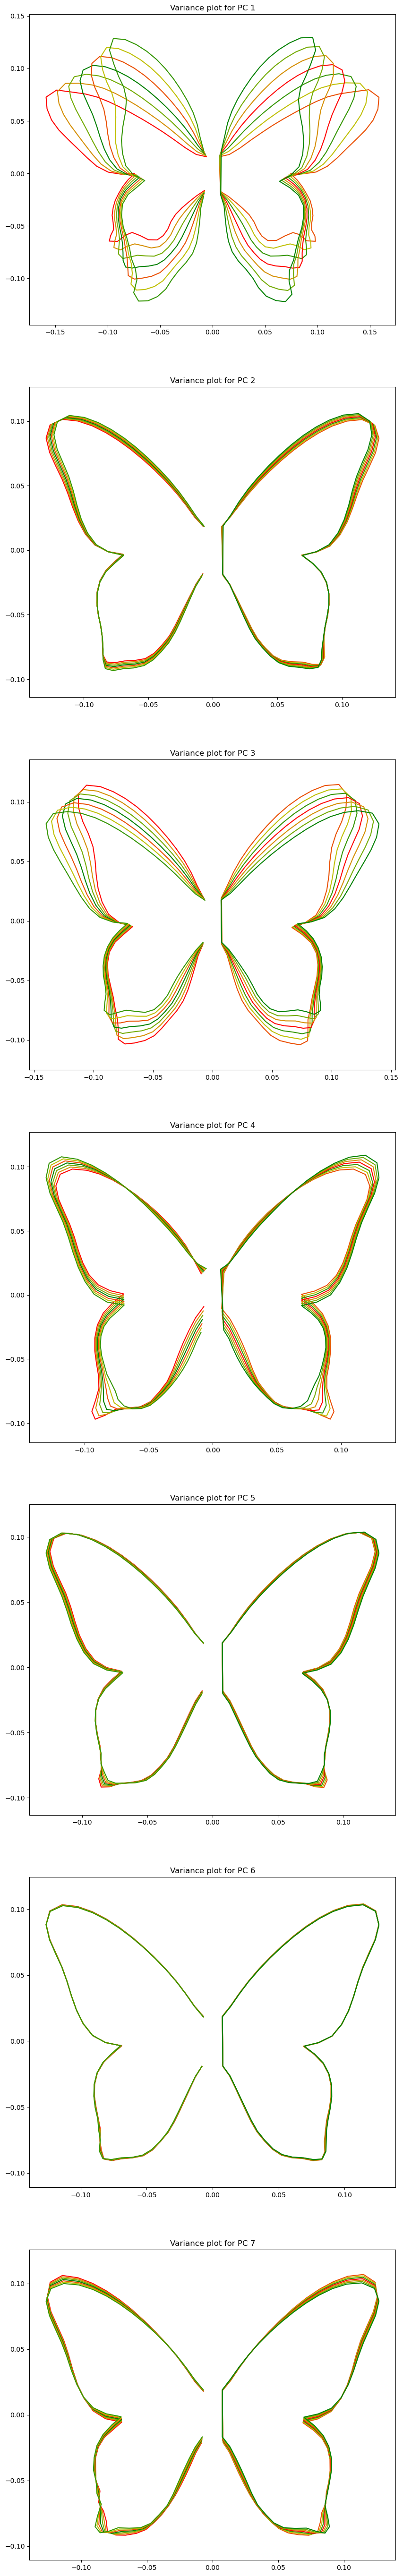

In [221]:


def old_var_plot(data, metadata, species=None, n=3, ks=[1,2]):
    # k:  component to analyze (counting from 1)
    # s: adjust exponent for better visualization
    
    if species is not None:
        data, _ = select_species(species, metadata, data)
    
    evals, evecs, cov, data_flatcent, data_flatmean = pca(data)
    #cov = np.cov(data_flatcent)
    #data_flatmean = np.mean(data_flatcent, axis=1)
    
    n2 = n*2+1
    gradient = list(Color("red").range_to(Color("green"), n2))
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', (gradient[i].hex for i in range(n2)))
    
    m = len(ks)
    
    plt.figure(figsize=(10, 10*m))
    
    a = np.arange(-n, n+1)

    for k in ks:
        evec = evecs[:, k] # kth eigenvector
        lam = evals[k]     # kth eigenvalue
        #std = (lam*200) ** -1    
        std = lam ** -0.3
        
        
        ek_space = std * (evec @ cov)
        
        # modify data by devs[i] standard deviations of ek_space
        devs = std * a
        
        butterflies_along_pc = data_flatmean + devs[:, None] * ek_space
        
        subplot = plt.subplot(m, 1, k)
        
        if species is not None:
            subplot.set_title('Variance plot for PC '+str(k)+' of '+species)
        else:
            subplot.set_title('Variance plot for PC '+str(k))
        
        for i in range(n2):
            plot_wings(unflat(butterflies_along_pc[i]),subplot)


N=3
#Ks=[1,2]
Ks = np.arange(1,8)

var_plot(data=butterflies, metadata=metadata, species=None, n=N,ks=Ks)